In [1]:
import os
import fastmri
import fastmri.data.transforms as T
from fastmri.data.subsample import RandomMaskFunc
from fastmri.data.mri_data import SliceDataset
import torch

# Check the data path
data_path = '../data/multicoil_test'

# Verify if the directory exists and list its contents
if not os.path.isdir(data_path):
    print(f"Directory {data_path} does not exist.")
else:
    files = os.listdir(data_path)
    if not files:
        print(f"No files found in {data_path}.")
    else:
        h5_files = [file for file in files if file.endswith('.h5')]
        if not h5_files:
            print(f"No .h5 files found in {data_path}.")
        else:
            print(f"Found {len(h5_files)} .h5 files in {data_path}:")

# Define the data transform
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
transform = T.UnetDataTransform(mask_func=mask_func, use_seed=True, which_challenge='multicoil')

print("Data transform defined successfully.")

# Define the dataset
train_data = SliceDataset(
    root=data_path,
    transform=transform,
    challenge='multicoil'
)

print("Dataset defined successfully.")
print(f"Number of slices in dataset: {len(train_data)}")

# DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, num_workers=0)

print("DataLoader created successfully.")
print(f"Number of batches in DataLoader: {len(train_loader)}")

# Iterate through the DataLoader to ensure it's working
for i, data in enumerate(train_loader):
    print(f"Batch {i + 1}: {data}")
    if i >= 2:  # Stop after a few batches to avoid too much output
        break


Found 186 .h5 files in ../data/multicoil_test:
Data transform defined successfully.
Dataset defined successfully.
Number of slices in dataset: 2956
DataLoader created successfully.
Number of batches in DataLoader: 2956
Batch 1: UnetSample(image=tensor([[[-0.8620, -0.8664, -0.8795,  ..., -0.8574, -0.8573, -0.8637],
         [-0.8607, -0.8666, -0.8588,  ..., -0.8698, -0.8702, -0.8601],
         [-0.8748, -0.8880, -0.8962,  ..., -0.8744, -0.8816, -0.8718],
         ...,
         [-0.8611, -0.8526, -0.8534,  ..., -0.8935, -0.8805, -0.8664],
         [-0.8827, -0.8864, -0.8575,  ..., -0.8863, -0.8780, -0.8751],
         [-0.8864, -0.8664, -0.8509,  ..., -0.8637, -0.8626, -0.8794]]]), target=tensor([[0.]]), mean=tensor([5.7648e-05]), std=tensor([5.8707e-05]), fname=('file_brain_AXFLAIR_200_6002527.h5',), slice_num=tensor([0]), max_value=tensor([0.], dtype=torch.float64))
Batch 2: UnetSample(image=tensor([[[-0.8456, -0.8616, -0.8551,  ..., -0.8306, -0.8611, -0.8553],
         [-0.8653, -0.876

In [3]:
# Step 2: Generate mock motion data and perform PCA
import numpy as np
from sklearn.decomposition import PCA
import os

def generate_mock_motion_data(num_samples=100, num_features=6, seq_length=150):
    """
    Generate a mock motion dataset with the given number of samples, features, and sequence length.

    Parameters:
    num_samples (int): Number of motion sequences.
    num_features (int): Number of features in each motion sequence.
    seq_length (int): Length of each motion sequence.

    Returns:
    numpy array: The generated mock motion data of shape (num_samples, seq_length, num_features).
    """
    # Simulate some random motion data
    motion_data = np.random.randn(num_samples, seq_length, num_features)
    
    return motion_data

def perform_pca_on_motion_data(motion_data, n_components=5, save_path='../Data/'):
    """
    Perform PCA on the given motion data and save the PCA components and mean curve as .npy files.

    Parameters:
    motion_data (numpy array): The motion data array of shape (num_samples, seq_length, num_features).
    n_components (int): Number of principal components to keep.
    save_path (str): Directory where to save the .npy files.
    """
    # Ensure the save path ends with a '/'
    if not save_path.endswith('/'):
        save_path += '/'

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Reshape motion data to (num_samples, seq_length * num_features)
    num_samples, seq_length, num_features = motion_data.shape
    reshaped_data = motion_data.reshape(num_samples, -1)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(reshaped_data)
    
    # Get the PCA components and mean curve
    pca_components = pca.components_
    mean_curve = pca.mean_
    
    # Save the PCA components and mean curve as .npy files
    np.save(save_path + 'pca_components.npy', pca_components)
    np.save(save_path + 'mean_curve.npy', mean_curve)
    
    print(f"PCA components and mean curve saved to {save_path}")

# Generate mock motion data
motion_data = generate_mock_motion_data(num_samples=100, num_features=6, seq_length=150)

# Perform PCA and save the components and mean curve
perform_pca_on_motion_data(motion_data, n_components=5, save_path='../Data')


PCA components and mean curve saved to ../Data/


In [6]:
# Step 3: Generate motion curves
def generate_motion_curves(pca_components, mean_curve, num_curves=1, num_components_per_step=6):
    motion_curves = []
    for i in range(num_curves):
        weights = np.random.uniform(-3, 3, size=(pca_components.shape[0],))
        motion_curve = mean_curve + np.dot(weights, pca_components)
        # Reshape to have six components per time step
        motion_curve = motion_curve.reshape(-1, num_components_per_step)
        motion_curves.append(motion_curve)
        print(f"Generated motion curve {i + 1}/{num_curves}")
    return np.array(motion_curves)

# Load PCA components and mean curve
pca_components = np.load('../Data/pca_components.npy')
mean_curve = np.load('../Data/mean_curve.npy')

# Print shapes for debugging
print(f"PCA components shape: {pca_components.shape}")
print(f"Mean curve shape: {mean_curve.shape}")

# Generate motion curves
motion_curves = generate_motion_curves(pca_components, mean_curve, num_curves=5)
print("Generated Motion Curves Shape:", motion_curves.shape)


PCA components shape: (5, 900)
Mean curve shape: (900,)
Generated motion curve 1/5
Generated motion curve 2/5
Generated motion curve 3/5
Generated motion curve 4/5
Generated motion curve 5/5
Generated Motion Curves Shape: (5, 150, 6)


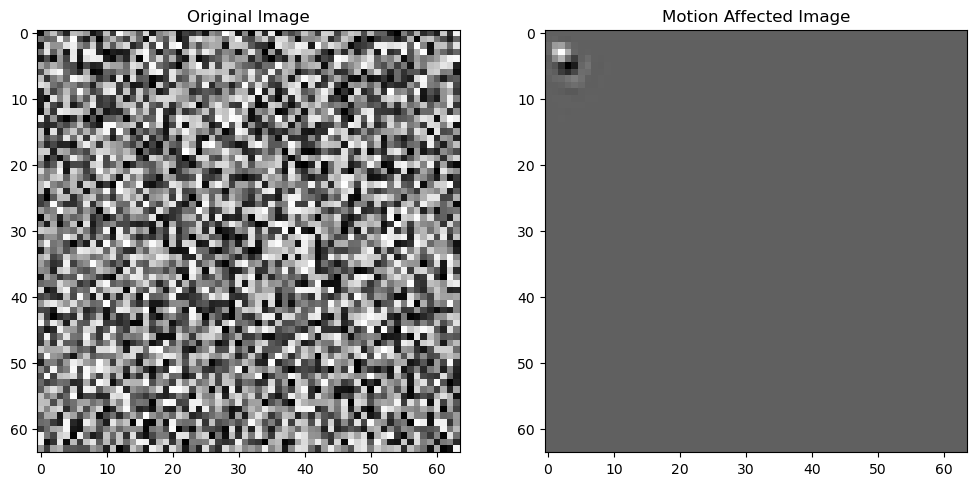

In [7]:
# Step 4: Apply motion curves to MRI images
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform

def apply_motion_curve_to_mri(image, motion_curve):
    """
    Apply a motion curve to an MRI image.
    
    Parameters:
    image (numpy array): The input MRI image.
    motion_curve (numpy array): The motion curve to apply.

    Returns:
    numpy array: The motion-affected MRI image.
    """
    transformed_image = np.copy(image)
    
    for t in range(motion_curve.shape[0]):
        tx, ty, tz, rx, ry, rz = motion_curve[t]
        transformation_matrix = np.eye(4)
        transformation_matrix[:3, :3] = np.array([
            [np.cos(rx), -np.sin(rx), 0],
            [np.sin(rx), np.cos(rx), 0],
            [0, 0, 1]
        ])
        transformed_image = affine_transform(transformed_image, transformation_matrix[:3, :3], offset=[tx, ty, tz])
    
    return transformed_image

# Example usage
image = np.random.rand(64, 64, 64)  # Replace with your actual MRI image
motion_curve = motion_curves[0]  # Use the first generated motion curve

motion_affected_image = apply_motion_curve_to_mri(image, motion_curve)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image[:, :, image.shape[2]//2], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Motion Affected Image")
plt.imshow(motion_affected_image[:, :, motion_affected_image.shape[2]//2], cmap='gray')
plt.show()

In [ ]:
# Step 5: Simulate motion artifacts on MRI data
import h5py

def simulate_motion_artifacts(mri_data_path, output_path, motion_curves):
    """
    Simulate motion artifacts on MRI data using generated motion curves.
    
    Parameters:
    mri_data_path (str): Path to the input MRI data file.
    output_path (str): Path to save the motion-affected MRI data.
    motion_curves (numpy array): The motion curves to apply.
    
    Returns:
    None
    """
    with h5py.File(mri_data_path, 'r') as mri_data_file:
        mri_data = mri_data_file['kspace'][:]  # Load k-space data
    
    # Apply motion curves to k-space data
    motion_affected_kspace = np.copy(mri_data)
    for idx, curve in enumerate(motion_curves):
        for t in range(curve.shape[0]):
            tx, ty, tz, rx, ry, rz = curve[t]
            transformation_matrix = np.eye(4)
            transformation_matrix[:3, :3] = np.array([
                [np.cos(rx), -np.sin(rx), 0],
                [np.sin(rx), np.cos(rx), 0],
                [0, 0, 1]
            ])
            motion_affected_kspace[idx] = affine_transform(motion_affected_kspace[idx], transformation_matrix[:3, :3], offset=[tx, ty, tz])
    
    # Save the motion-affected k-space data
    with h5py.File(output_path, 'w') as output_file:
        output_file.create_dataset('kspace', data=motion_affected_kspace)

# Example usage
mri_data_path = '../mri_data.h5'  # Replace with your actual MRI data file path
output_path = '../motion_affected_mri_data.h5'
simulate_motion_artifacts(mri_data_path, output_path, motion_curves)

In [ ]:
# Step 6: Visualize the results
import h5py
import matplotlib.pyplot as plt

def visualize_mri_data(original_path, motion_affected_path):
    with h5py.File(original_path, 'r') as original_file, h5py.File(motion_affected_path, 'r') as motion_file:
        original_kspace = original_file['kspace'][:]
        motion_affected_kspace = motion_file['kspace'][:]
        
        original_image = np.fft.ifftn(np.fft.ifftshift(original_kspace))
        motion_affected_image = np.fft.ifftn(np.fft.ifftshift(motion_affected_kspace))
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(np.abs(original_image[0, :, :, original_image.shape[2]//2]), cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title("Motion Affected Image")
        plt.imshow(np.abs(motion_affected_image[0, :, :, motion_affected_image.shape[2]//2]), cmap='gray')
        plt.show()

# Example usage
original_path = '../mri_data.h5'
motion_affected_path = '../motion_affected_mri_data.h5'
visualize_mri_data(original_path, motion_affected_path)

Generated motion curve 1/1
Generated Motion Curves Shape: (1, 150, 6)


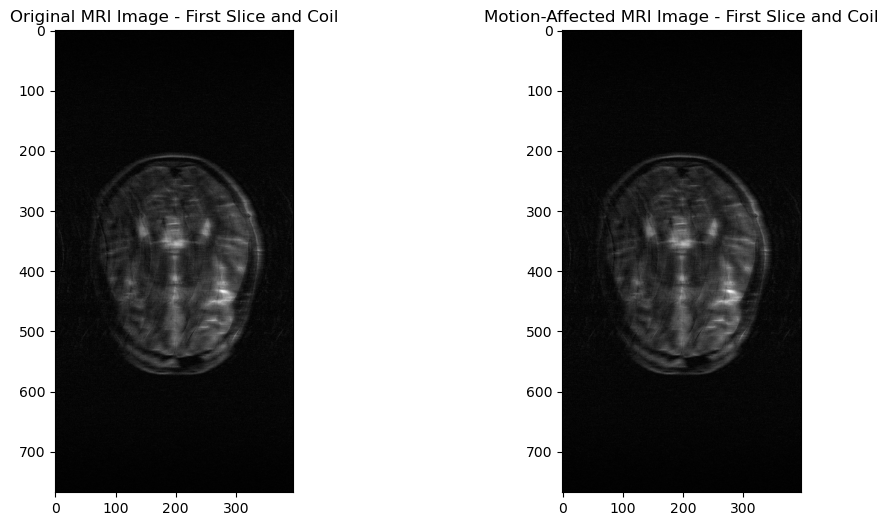

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

def apply_motion_curve(k_space_data, motion_curve):
    motion_affected_data = k_space_data.copy()
    seq_length, num_features = motion_curve.shape

    # Apply translation based on motion curve
    for i in range(seq_length):
        translation = motion_curve[i, :2]  # Using the first two components for translation

        # Apply translation
        motion_affected_data = np.roll(motion_affected_data, int(translation[0]), axis=0)
        motion_affected_data = np.roll(motion_affected_data, int(translation[1]), axis=1)

    return motion_affected_data

# Load the motion curves
pca_components = np.load('../Data/pca_components.npy')
mean_curve = np.load('../Data/mean_curve.npy')

def generate_motion_curves(pca_components, mean_curve, num_curves=1, num_components_per_step=6):
    motion_curves = []
    for i in range(num_curves):
        weights = np.random.uniform(-3, 3, size=(pca_components.shape[0],))
        motion_curve = mean_curve + np.dot(weights, pca_components)
        # Reshape to have six components per time step
        motion_curve = motion_curve.reshape(-1, num_components_per_step)
        motion_curves.append(motion_curve)
        print(f"Generated motion curve {i + 1}/{num_curves}")
    return np.array(motion_curves)

# Generate motion curves
motion_curves = generate_motion_curves(pca_components, mean_curve, num_curves=1)
print("Generated Motion Curves Shape:", motion_curves.shape)

# Load the MRI data
file_path = '../Data/multicoil_test/file_brain_AXT2_200_6002495.h5'

with h5py.File(file_path, 'r') as f:
    mri_data = f['kspace'][:]

# Take the inverse Fourier transform to get the image for the first slice and coil
kspace_slice = mri_data[0, 0, :, :]  # Selecting the first slice and first coil

# Apply single motion curve
motion_affected_kspace_slice = apply_motion_curve(kspace_slice, motion_curves[0])

# Reconstruct images from k-space data
original_image_slice = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kspace_slice)))
motion_affected_image_slice = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(motion_affected_kspace_slice)))

# Normalize the images for better visualization
original_image_slice = np.abs(original_image_slice)
motion_affected_image_slice = np.abs(motion_affected_image_slice)

original_image_slice = (original_image_slice - np.min(original_image_slice)) / (np.max(original_image_slice) - np.min(original_image_slice))
motion_affected_image_slice = (motion_affected_image_slice - np.min(motion_affected_image_slice)) / (np.max(motion_affected_image_slice) - np.min(motion_affected_image_slice))

# Visualize the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original MRI Image - First Slice and Coil")
plt.imshow(original_image_slice, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Motion-Affected MRI Image - First Slice and Coil")
plt.imshow(motion_affected_image_slice, cmap='gray')

plt.show()


Generated motion curve 1/5
Generated motion curve 2/5
Generated motion curve 3/5
Generated motion curve 4/5
Generated motion curve 5/5
Generated motion curves shape: (5, 150, 6)
First motion curve:
[[ 0.13505652 -0.07683169  0.13656808 -0.05456627  0.01030051  0.04403916]
 [-0.2853662  -0.04963355 -0.15021555 -0.2002925   0.10249591  0.10680289]
 [-0.26324995 -0.06481603  0.10559448 -0.00200674 -0.38135552 -0.14839943]
 [ 0.08758702  0.1357176   0.15605176  0.1150806   0.07896104 -0.06553471]
 [ 0.10642451  0.00786705 -0.07934095  0.03401531  0.05537834 -0.05538638]
 [-0.1338196   0.14058971 -0.20176959 -0.06975752 -0.32346008 -0.01620512]
 [ 0.17405228  0.23929508  0.13360535  0.09803334 -0.00352219 -0.29102811]
 [-0.15393448 -0.26963656  0.08577036 -0.02213713  0.17741247 -0.17315953]
 [ 0.06940622  0.02113028  0.33622532  0.03120049 -0.12893869  0.03299966]
 [ 0.22328514  0.00658999  0.02853456  0.19897794  0.01813808 -0.18230097]
 [ 0.00590546 -0.09060649  0.2816382   0.15550571 -0

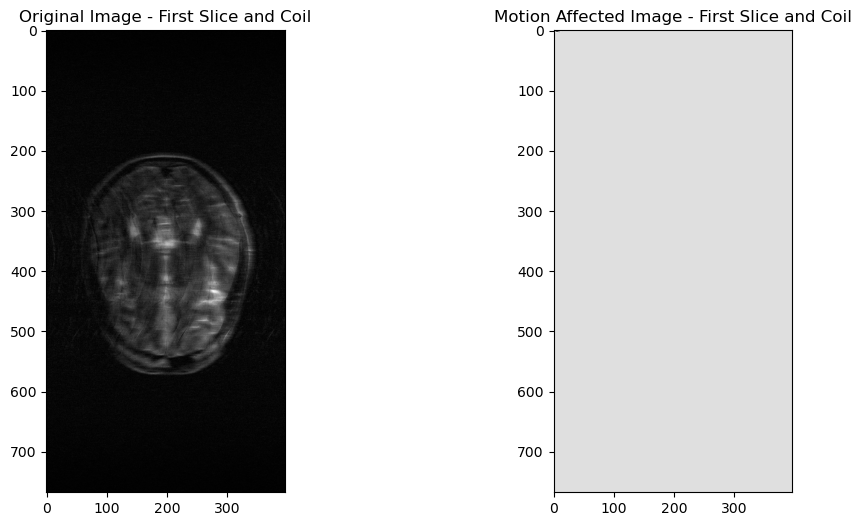

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
import h5py

# Function to apply motion curves to MRI image
def apply_motion_curve_to_mri(image_slice, motion_curve):
    transformed_slice = np.copy(image_slice)
    
    for t in range(motion_curve.shape[0]):
        tx, ty, rx = motion_curve[t][:3]  # Only using tx, ty, and rx for 2D transformation
        transformation_matrix = np.eye(3)
        transformation_matrix[:2, :2] = np.array([
            [np.cos(rx), -np.sin(rx)],
            [np.sin(rx), np.cos(rx)]
        ])
        transformed_slice = affine_transform(transformed_slice, transformation_matrix[:2, :2], offset=[tx, ty])
    
    return transformed_slice

# Load PCA components and mean curve
pca_components = np.load('../Data/pca_components.npy')
mean_curve = np.load('../Data/mean_curve.npy')

# Generate motion curves
motion_curves = generate_motion_curves(pca_components, mean_curve, num_curves=5)
print(f"Generated motion curves shape: {motion_curves.shape}")
print(f"First motion curve:\n{motion_curves[0]}")

# Load the MRI data
file_path = '../Data/multicoil_test/file_brain_AXT2_200_6002495.h5'  # Update with the path to your actual MRI data file

with h5py.File(file_path, 'r') as f:
    mri_data = f['kspace'][:]

# Take the inverse Fourier transform to get the image for the first slice and coil
kspace_slice = mri_data[0, 0, :, :]  # Selecting the first slice and first coil
image_slice = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kspace_slice)))
image_slice = np.abs(image_slice)

# Normalize the image for better visualization
image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))

# Apply motion curve to MRI image
motion_curve = motion_curves[0]
motion_affected_image_slice = apply_motion_curve_to_mri(image_slice, motion_curve)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image - First Slice and Coil")
plt.imshow(image_slice, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Motion Affected Image - First Slice and Coil")
plt.imshow(motion_affected_image_slice, cmap='gray')
plt.show()


In [19]:
import numpy as np

# Load PCA components and mean curve from .npy files
pca_components = np.load('../Data/pca_components.npy')
mean_curve = np.load('../Data/mean_curve.npy')

def generate_motion_curves(pca_components, mean_curve, num_curves=5, num_components_per_step=6):
    """
    Generate motion curves using PCA components and mean curve.

    Parameters:
    pca_components (numpy array): The PCA components array of shape (n_components, seq_length * num_features).
    mean_curve (numpy array): The mean curve array of shape (seq_length * num_features).
    num_curves (int): Number of motion curves to generate.
    num_components_per_step (int): Number of features in each motion sequence step.

    Returns:
    numpy array: The generated motion curves of shape (num_curves, seq_length, num_features).
    """
    motion_curves = []
    for i in range(num_curves):
        weights = np.random.uniform(-3, 3, size=(pca_components.shape[0],))
        motion_curve = mean_curve + np.dot(weights, pca_components)
        # Reshape to have six components per time step
        motion_curve = motion_curve.reshape(-1, num_components_per_step)
        motion_curves.append(motion_curve)
        print(f"Generated motion curve {i + 1}/{num_curves}")
    return np.array(motion_curves)

# Generate motion curves
motion_curves = generate_motion_curves(pca_components, mean_curve, num_curves=5)

# Display the shape of the generated motion curves and the first motion curve
print("Generated Motion Curves Shape:", motion_curves.shape)
print("First Motion Curve:\n", motion_curves[0])


Generated motion curve 1/5
Generated motion curve 2/5
Generated motion curve 3/5
Generated motion curve 4/5
Generated motion curve 5/5
Generated Motion Curves Shape: (5, 150, 6)
First Motion Curve:
 [[ 3.80996272e-02  1.97682777e-02  2.24059481e-01  2.47823763e-01
  -2.07878287e-01 -9.05636693e-02]
 [-2.40894812e-01  3.13962484e-04 -1.13297752e-01  1.37467384e-01
   2.65819278e-01  2.23173199e-02]
 [-5.20124536e-02  1.78215233e-01  1.07180707e-01 -6.43392834e-02
  -6.89170633e-02  1.39972170e-01]
 [-2.53755156e-02  1.06246902e-01 -1.95474601e-01  2.55146268e-02
  -9.12628641e-02  1.07457715e-02]
 [-1.73521168e-01  1.47613291e-01  2.08550675e-01  1.63868607e-01
   1.40891758e-01  8.77759525e-02]
 [-4.29843598e-03  1.90788228e-01 -1.25137961e-01 -9.75777656e-02
   1.20140609e-01 -1.28098608e-01]
 [ 9.88038855e-02  1.10439522e-01  4.30181574e-02  6.76424018e-03
  -5.42019189e-02 -5.69701001e-02]
 [ 2.15791834e-01 -1.11850339e-01 -1.38493285e-01  1.75891016e-01
   3.51136432e-02 -8.6852090

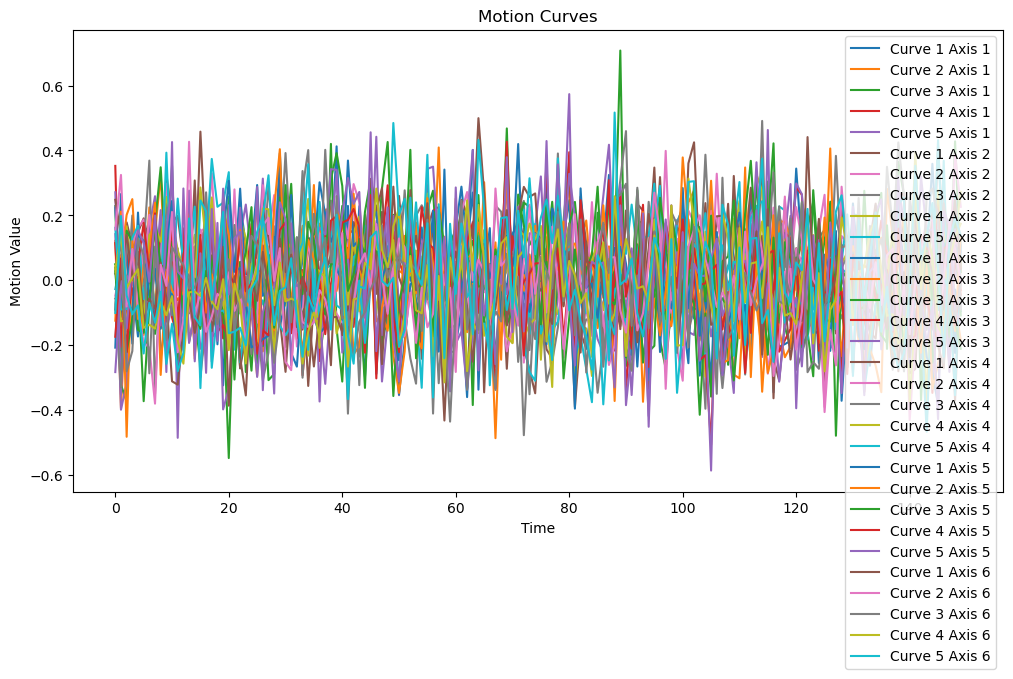

In [20]:
import matplotlib.pyplot as plt

# Plot motion curves
plt.figure(figsize=(12, 6))
for i in range(motion_curves.shape[2]):
    for j in range(motion_curves.shape[0]):
        plt.plot(motion_curves[j, :, i], label=f'Curve {j+1} Axis {i+1}')
plt.title('Motion Curves')
plt.xlabel('Time')
plt.ylabel('Motion Value')
plt.legend()
plt.show()


Generated motion curve 1/1
Generated Motion Curves Shape: (1, 150, 6)


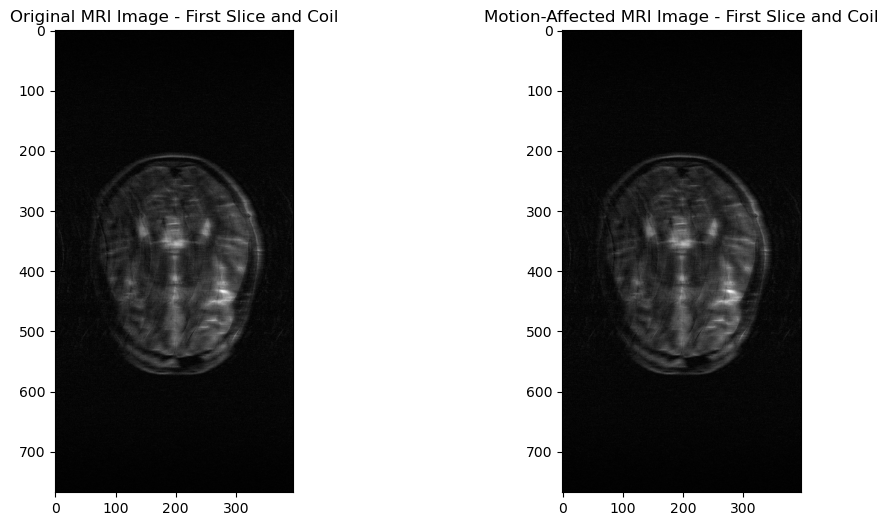

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

def apply_motion_curve(k_space_data, motion_curve):
    motion_affected_data = k_space_data.copy()
    seq_length, num_features = motion_curve.shape

    # Apply translation based on motion curve
    for i in range(seq_length):
        translation = motion_curve[i, :2]  # Using the first two components for translation

        # Apply translation
        motion_affected_data = np.roll(motion_affected_data, int(translation[0]), axis=0)
        motion_affected_data = np.roll(motion_affected_data, int(translation[1]), axis=1)

    return motion_affected_data

# Load the motion curves
pca_components = np.load('../Data//pca_components.npy')
mean_curve = np.load('../Data/mean_curve.npy')

def generate_motion_curves(pca_components, mean_curve, num_curves=1, num_components_per_step=6):
    motion_curves = []
    for i in range(num_curves):
        weights = np.random.uniform(-3, 3, size=(pca_components.shape[0],))
        motion_curve = mean_curve + np.dot(weights, pca_components)
        # Reshape to have six components per time step
        motion_curve = motion_curve.reshape(-1, num_components_per_step)
        motion_curves.append(motion_curve)
        print(f"Generated motion curve {i + 1}/{num_curves}")
    return np.array(motion_curves)

# Generate motion curves
motion_curves = generate_motion_curves(pca_components, mean_curve, num_curves=1)
print("Generated Motion Curves Shape:", motion_curves.shape)

# Load the MRI data
file_path = '../Data/multicoil_test/file_brain_AXT2_200_6002495.h5'

with h5py.File(file_path, 'r') as f:
    mri_data = f['kspace'][:]

# Select a single slice's k-space data for visualization
kspace_slice = mri_data[0, 0, :, :]  # Selecting the first slice and first coil

# Apply single motion curve
motion_affected_kspace_slice = apply_motion_curve(kspace_slice, motion_curves[0])

# Save the motion-affected k-space data
np.save('../Data/motion_affected_kspace_slice.npy', motion_affected_kspace_slice)

# Reconstruct images from k-space data
original_image_slice = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kspace_slice)))
motion_affected_image_slice = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(motion_affected_kspace_slice)))

# Normalize the images for better visualization
original_image_slice = np.abs(original_image_slice)
motion_affected_image_slice = np.abs(motion_affected_image_slice)

original_image_slice = (original_image_slice - np.min(original_image_slice)) / (np.max(original_image_slice) - np.min(original_image_slice))
motion_affected_image_slice = (motion_affected_image_slice - np.min(motion_affected_image_slice)) / (np.max(motion_affected_image_slice) - np.min(motion_affected_image_slice))

# Visualize the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original MRI Image - First Slice and Coil")
plt.imshow(original_image_slice, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Motion-Affected MRI Image - First Slice and Coil")
plt.imshow(motion_affected_image_slice, cmap='gray')

plt.show()
